## Machine Learning II Project - 2023/24

### Clustering Algorithms

#### Group 18:
- Suelen Faruk, 20221997
- Vidhi Rajanikante, 20221982

### Imports

In [1]:
# Pandas Library
import pandas as pd

# Numpy Library & Random
import numpy as np
import random

# Clustering ALgorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from minisom import MiniSom
from sklearn.neighbors import NearestNeighbors

# Visualization Libraries
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import umap

# Metrics
from sklearn.metrics import silhouette_score as shs
from sklearn.metrics import confusion_matrix

### Pre-defined functions and snippets of code

In [2]:
# ensuring that all the columns of the dataframe are shown
pd.set_option('display.max_columns', None)

In [3]:
# configuring the size and appearance of the plots generated in this notebook
plt.rcParams['figure.figsize'] = [16, 8]
font = {'weight': 'bold', 
       'size': 14}
plt.rc('font', **font)

The two following functions have been shared by Yehor Malakhov (20221691) in order to ease plotting the UMAPs and dendrograms.

In [4]:
def visualize_dimensionality_reduction(transformation, targets):
    '''Author: Yehor Malakhov, 20221691@novaims.unl.pt''' 
    
    # create a scatter plot of the t-SNE output
    plt.scatter(transformation[:, 0], transformation[:, 1],
                c=np.array(targets).astype(int), cmap=plt.cm.tab20)

    labels = np.unique(targets)

    cmap = plt.cm.tab20
    norm = plt.Normalize(vmin=min(np.array(labels).astype(int)), vmax=max(np.array(labels).astype(int)))
    rgba_values = cmap(norm(labels))

    # create a legend with the class labels and colors
    handles = [plt.scatter([], [], c=rgba, label=label) for rgba, label in zip(rgba_values, labels)]
    plt.legend(handles=handles, title='Classes')

    plt.show()

In [5]:
def plot_dendrogram(model, **kwargs):
    """
    ** Author: Yehor Malakhov **
    Create linkage matrix and then plot the dendrogram
    Arguments:
    - model(HierarchicalClustering Model): hierarchical clustering model.
    - **kwargs
    Returns:
    None, but dendrogram plot is produced.
    """
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Importing dataset (after preprocessing)

In [6]:
# Load the preprocessed DataFrame from a pickle file
f1 = pd.read_pickle('files_toimport/file1.pkl')
f1_rb = pd.read_pickle('files_toimport/f1_rb.pkl')

In [7]:
display(f1)
display(f1_rb)

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,spend_groceries,spend_electronics,typical_hour,spend_vegetables,spend_nonalcohol_drinks,spend_alcohol_drinks,spend_meat,spend_fish,spend_hygiene,spend_videogames,spend_petfood,total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,customer_graduate,cust_buy_yrs
0,39634,David Frink,M,1964,1,1,1,2,18306.0,7106.0,17,484.0,604.0,943.0,2226.0,4056.0,2174.0,3946.0,2514.0,32,0.072206,2010,Nal,14.0
1,43460,Belinda Terry,F,1988,1,0,1,2,5015.0,1334.0,8,344.0,374.0,1217.0,1068.0,1925.0,2115.0,1028.0,1987.0,2566,0.206227,2014,Nal,10.0
2,23937,Evelyn Calico,F,1969,0,1,1,3,3097.0,4073.0,10,301.0,852.0,1731.0,446.0,2347.0,1306.0,1504.0,2018.0,1282,0.136168,2009,Nal,15.0
3,2431,Ora Boggess,F,1941,0,0,0,1,10825.0,207.0,17,153.0,252.0,60.0,285.0,151.0,53.0,0.0,4135.0,70,0.215852,2007,Nal,17.0
4,10090,Lonnie Hopson,M,2001,0,0,0,1,697.0,570.0,14,8.0,33.0,2833.0,54.0,172.0,587.0,223.0,64.0,4,0.181023,2024,Nal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43626,48487,Amelia Crawford,F,1983,1,1,0,1,7189.0,6293.0,17,678.0,741.0,639.0,1569.0,3779.0,1748.0,4387.0,2812.0,14,0.233259,2016,Nal,8.0
43627,24856,Silvia Ramos,F,1992,1,1,1,1,11238.0,11490.0,12,602.0,557.0,1503.0,2610.0,3893.0,1621.0,3831.0,2726.0,25,0.060977,2014,Nal,10.0
43628,21373,Addie Coronel,F,1994,0,0,0,1,6059.0,241.0,12,289.0,420.0,43.0,331.0,142.0,179.0,0.0,11242.0,44,0.097672,2017,Nal,7.0
43629,19527,Msc. Mary Ross,F,1989,1,0,1,1,3098.0,425.0,6,866.0,369.0,222.0,1.0,0.0,393.0,210.0,422.0,178,0.182188,2007,Master_Degree,17.0


,customer_id,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,spend_groceries,spend_electronics,typical_hour,spend_vegetables,spend_nonalcohol_drinks,spend_alcohol_drinks,spend_meat,spend_fish,spend_hygiene,spend_videogames,spend_petfood,total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction
0,0.586708,-0.21875,0.0,0.0,0.0,1.0,3.219860,2.782535,0.571429,0.266106,0.703422,1.243513,1.810840,2.457040,1.414085,3.736494,0.964706,-0.500000,-0.667885,-0.166667
1,0.739975,0.53125,0.0,-1.0,0.0,1.0,0.213526,0.323749,-0.714286,-0.126050,-0.171103,1.790419,0.580234,0.918412,1.358685,0.519294,0.654706,5.259091,0.004977,0.500000
2,-0.042102,-0.06250,-1.0,0.0,0.0,2.0,-0.220312,1.490522,-0.428571,-0.246499,1.646388,2.816367,-0.080765,1.223105,0.599061,1.044101,0.672941,2.340909,-0.346757,-0.333333
3,-0.903617,-0.93750,-1.0,-1.0,-1.0,0.0,1.527709,-0.156337,0.571429,-0.661064,-0.634981,-0.518962,-0.251860,-0.362455,-0.577465,-0.614112,1.918235,-0.413636,0.053300,-0.666667
4,-0.596803,0.93750,-1.0,-1.0,-1.0,0.0,-0.763176,-0.001704,0.142857,-1.067227,-1.467681,5.015968,-0.497343,-0.347292,-0.076056,-0.368247,-0.476471,-0.563636,-0.121559,2.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43626,0.941353,0.37500,0.0,0.0,-1.0,0.0,0.705270,2.436209,0.571429,0.809524,1.224335,0.636727,1.112646,2.257040,1.014085,4.222712,1.140000,-0.540909,0.140694,0.833333
43627,-0.005288,0.65625,0.0,0.0,0.0,0.0,1.621126,4.650053,-0.142857,0.596639,0.524715,2.361277,2.218916,2.339350,0.894836,3.609702,1.089412,-0.515909,-0.724261,0.500000
43628,-0.144814,0.71875,-1.0,-1.0,-1.0,0.0,0.449672,-0.141853,-0.142857,-0.280112,0.003802,-0.552894,-0.202976,-0.368953,-0.459155,-0.614112,6.098824,-0.472727,-0.540030,1.000000
43629,-0.218764,0.56250,0.0,-1.0,0.0,0.0,-0.220086,-0.063472,-1.000000,1.336134,-0.190114,-0.195609,-0.553666,-0.471480,-0.258216,-0.382580,-0.265882,-0.168182,-0.115709,-0.666667


### DBSCAN
Since we were getting bad results with a large `min_samples`, with both `n_neighbors` and `min_samples` have to be the same number, we decided to play around with it and decrease it further. Though it was giving us horrible results even after decreasing the `min_samples`, we came to a point that the results were basically the same when we were ranging between 8-13 for the `min_samples`. So we decided to not use it for clustering, but for for detecting multidimensional outliers instead.

In [8]:
ms = 12
# min samples set to 12 after trial and error done
# decreasing the ms making the umpa visualization horrible and increasing it doesn't make much difference

In [9]:
nn_model = NearestNeighbors(n_neighbors=ms)
nrs = nn_model.fit(f1_rb)
distances_rb, indices_rb = nrs.kneighbors(f1_rb)
distances_rb = np.sort(distances_rb, axis=0)
distances_rb1 = distances_rb[:,1]

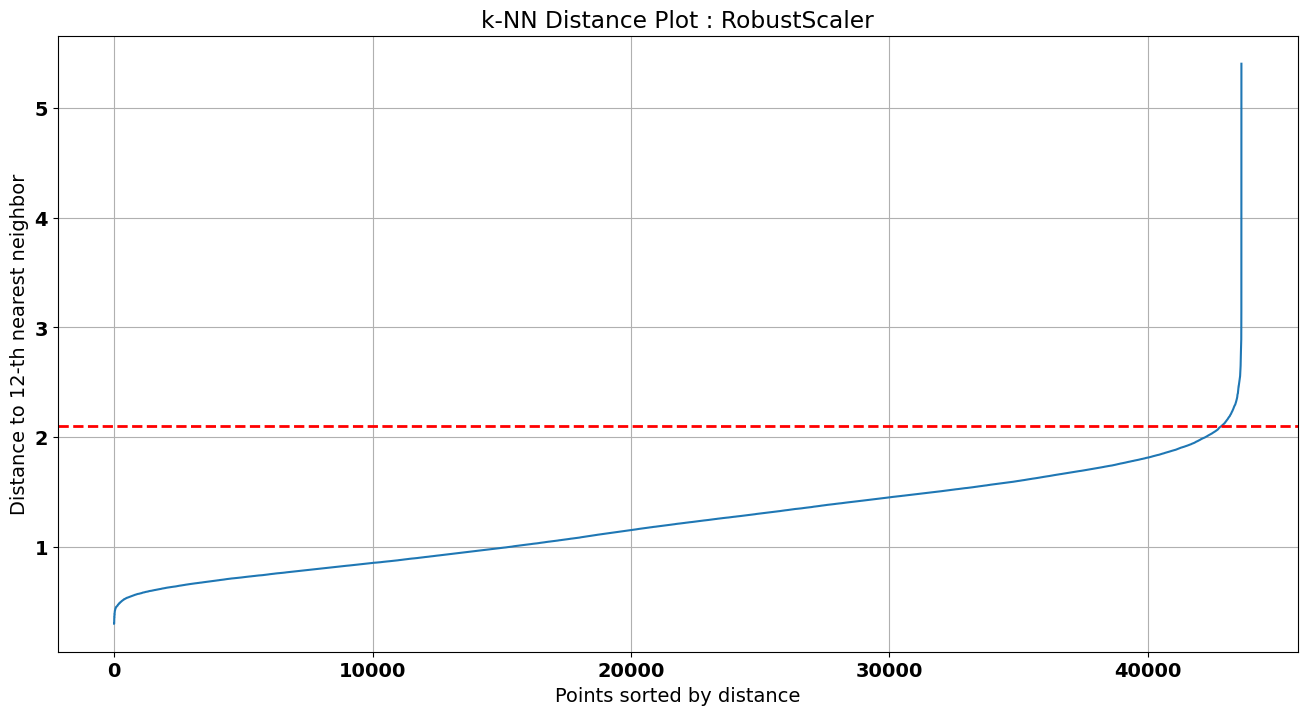

In [10]:
# plotting the knee plot to obtain the eps value 
plt.plot(distances_rb1)
plt.grid(visible=True)
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to {}-th nearest neighbor'.format(ms))
plt.title('k-NN Distance Plot : RobustScaler')
plt.axhline(y=2.1, color='r', linestyle='--', linewidth=2)
plt.show()

In [11]:
f1['cl_db'] = DBSCAN(
    eps=2.1, min_samples=ms
    ).fit_predict(f1_rb)

In [12]:
display(f1['cl_db'].value_counts())
display(shs(f1_rb, f1['cl_db']))

 1    36549
 0     5389
-1     1352
 2      341
Name: cl_db, dtype: int64

0.294005242656297

Since we decided to use the DBSCAN as a way to detect multidimensional outliers, we can see that 1352 observations, that are considered to be part of cluster -1 in DBSCAN, are considered to be noise i.e. our multidimensional outliers.

#### UMAP Visualization on DBSCAN results

C:\Users\Vidhi Rajanikante\Downloads\AnacondaDistribution.VR\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence

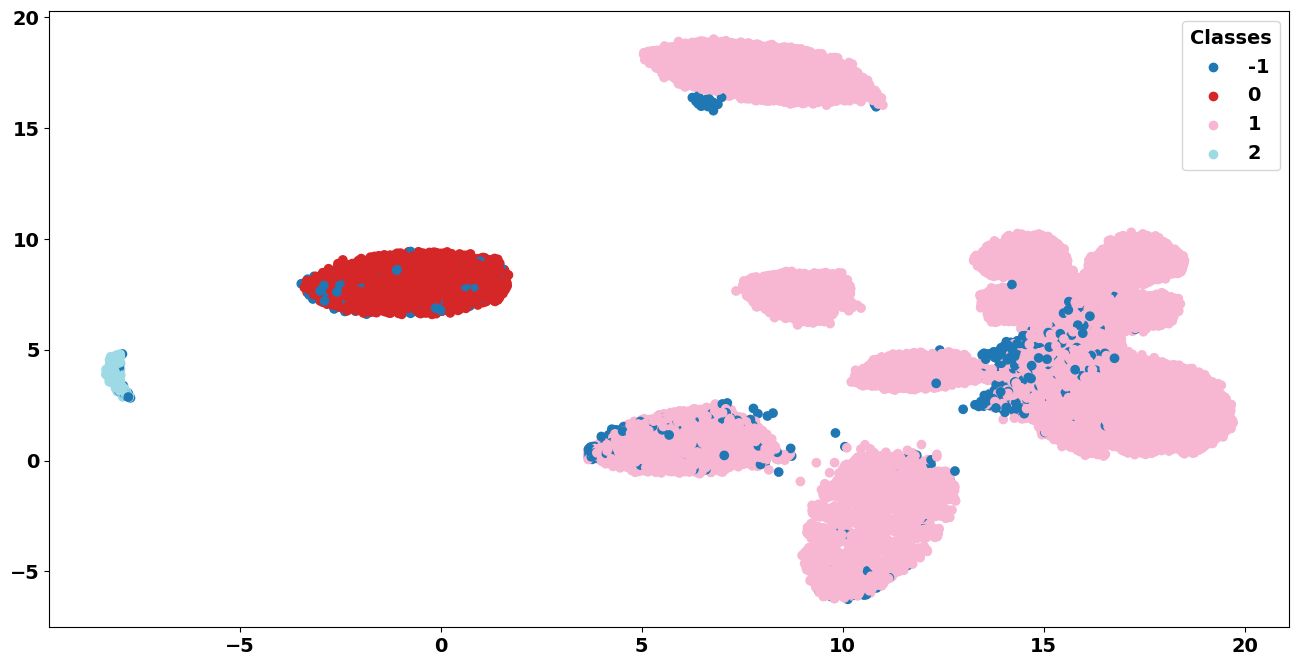

In [13]:
umap_object = umap.UMAP(n_neighbors=200, min_dist=0.5, random_state=42)
train = f1_rb
labels = f1[['cl_db']].sort_index()
umap_embedding = umap_object.fit_transform(train)
visualize_dimensionality_reduction(umap_embedding, labels)

From the visualization above, we can see that the points related to the -1 cluster are all spread out. Thus, we decided not to get rid of these outliers as they may contain important information.

### Tandem Approach 1: K-means + Hierarchical Clustering

In [14]:
# setting a high number of clusters as they will then be reduced, due to the tandem approach 
km_rb = KMeans(n_clusters=30, random_state=0).fit_predict(f1_rb) 
km_rb_1 = f1_rb.copy()
km_rb_1['clkm_rb'] = km_rb
km_rb_1 = km_rb_1.groupby('clkm_rb').mean()

# another copy to then substitute with the correct cluster
km_rb_2 = f1_rb.copy()
km_rb_2['clkm_rb'] = km_rb

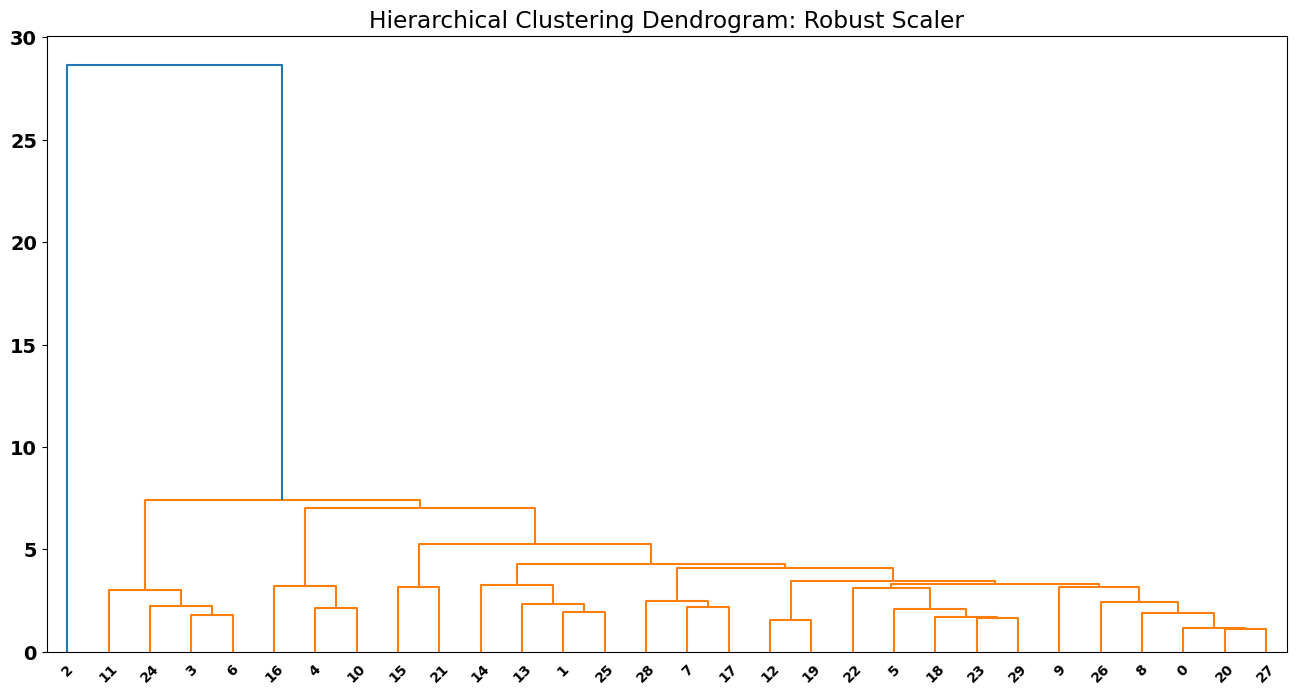

Number of clusters chosen:10


In [15]:
# apply agglomerative clustering on obtained kmeans results
hc_rbkm = AgglomerativeClustering(
    n_clusters = None, distance_threshold = 0,
    linkage='average').fit(km_rb_1)

# plot dendrogram to chose final number of clusters
plot_dendrogram(hc_rbkm, truncate_mode="level", p=50)
plt.title('Hierarchical Clustering Dendrogram: Robust Scaler')
plt.show()


n_clusters = int(input('Number of clusters chosen:'))
# apply final agglomerative clustering on the number of clusters chosen
ta_rbkm = AgglomerativeClustering(
    n_clusters = n_clusters,
    linkage='average').fit_predict(km_rb_1)

# add these to the first df with kmeans results
km_rb_1['final_clkm'] = ta_rbkm
km_rb_1 = km_rb_1[['final_clkm']]

In [16]:
# pandas Series containing the final clusters
final_kmrb = km_rb_2['clkm_rb'].map(km_rb_1['final_clkm'])
# add these values to the original dataset
f1['cl_km'] = final_kmrb

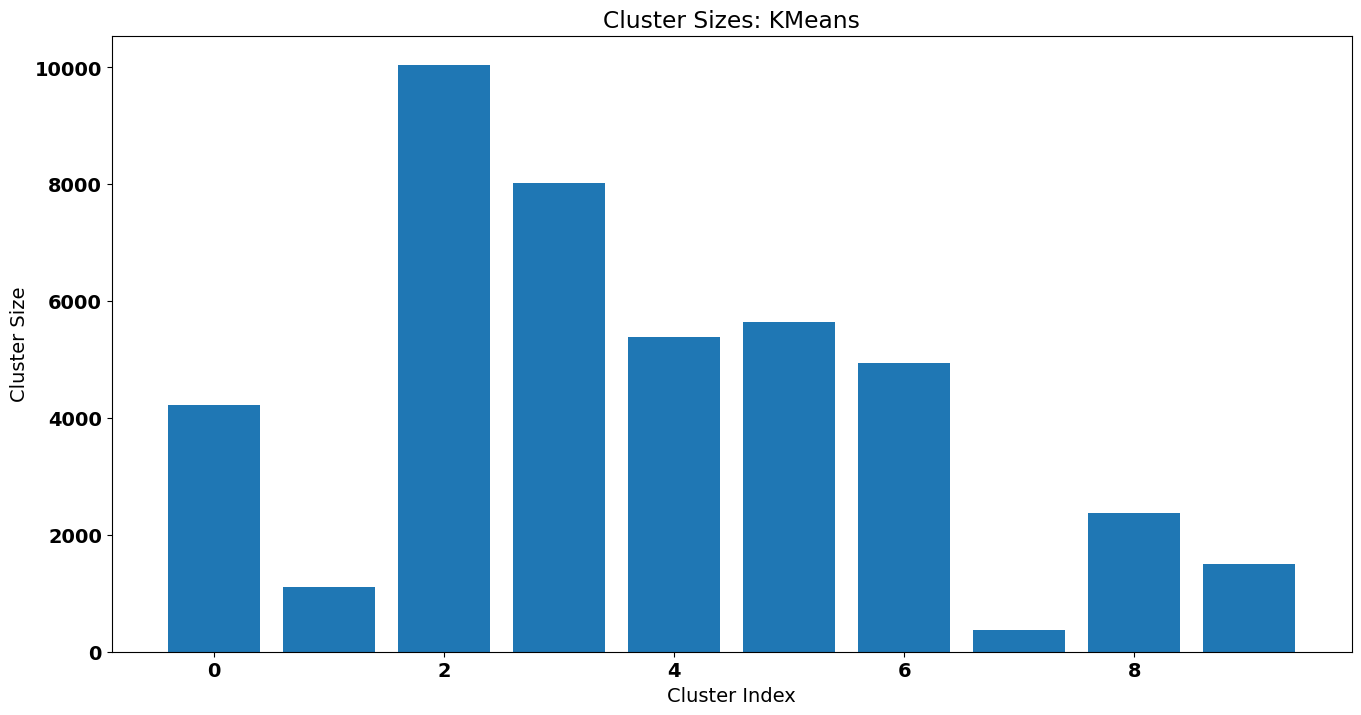

In [17]:
# obtain the cluster sizes
cluster_sizes = f1['cl_km'].value_counts()

# plot to see the varying cluster sizes
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes: KMeans')
plt.show()

#### UMAP Visualization on TA1 - 10 clusters

C:\Users\Vidhi Rajanikante\Downloads\AnacondaDistribution.VR\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence

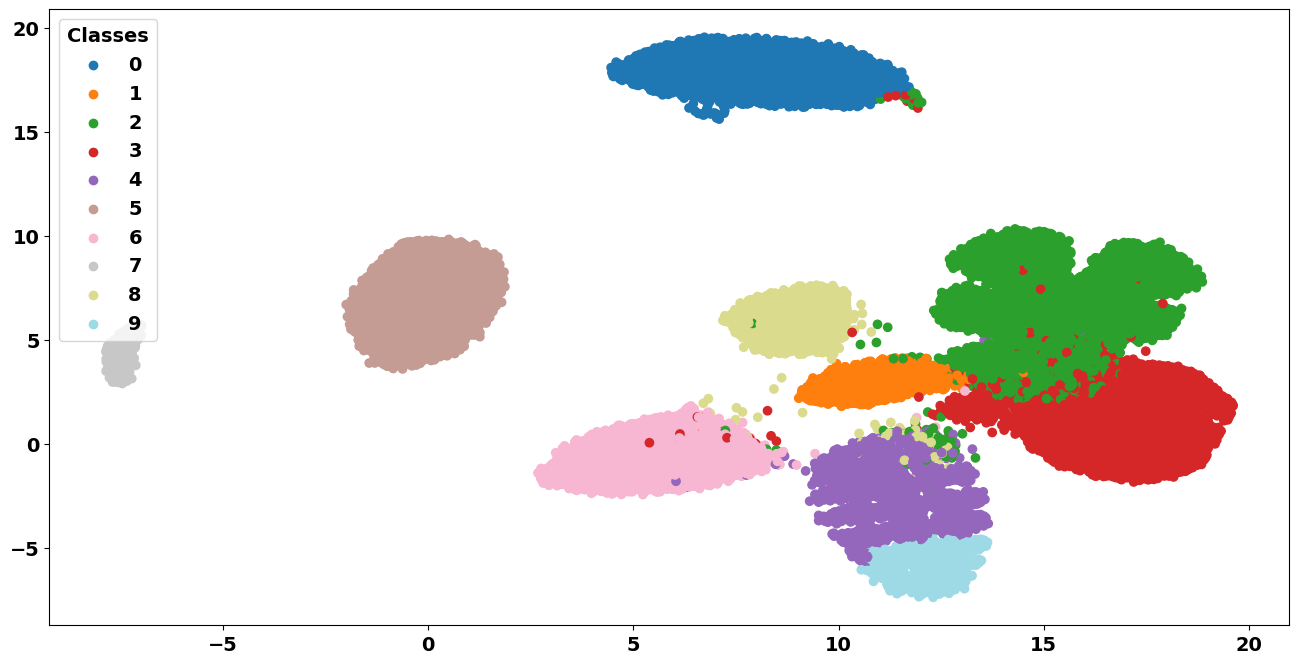

In [18]:
umap_object = umap.UMAP(n_neighbors=209, min_dist=0.7, random_state=42)
train = f1_rb.sort_index()
labels = f1[['cl_km']].sort_index()
umap_embedding = umap_object.fit_transform(train)
visualize_dimensionality_reduction(umap_embedding, labels)

### Tandem Approach 1: SOM + Hierarchical Clustering

In [19]:
# parameter values chosen through trial and error
som_rb = MiniSom(5, 5, 20, sigma=0.6, learning_rate=0.6, neighborhood_function='gaussian', random_seed=42)
som_rb.train(np.array(f1_rb), 2000)

# create an array which will have the winner nodes of each point from the som results
f1_rb_arr = np.array(f1_rb)
nodes_rbsom = [str(som_rb.winner(f1_rb_arr[i])) for i in range(len(f1_rb_arr))]

# storing the nodes in our scaled df
som_rb = f1_rb.copy()
som_rb['node'] = nodes_rbsom

# another copy to then substitute with the correct clusters
f1_rbsom = f1_rb.copy()
f1_rbsom["node"] = nodes_rbsom
# having the mean represent each node 
f1_rbsom = f1_rbsom.groupby("node").mean()

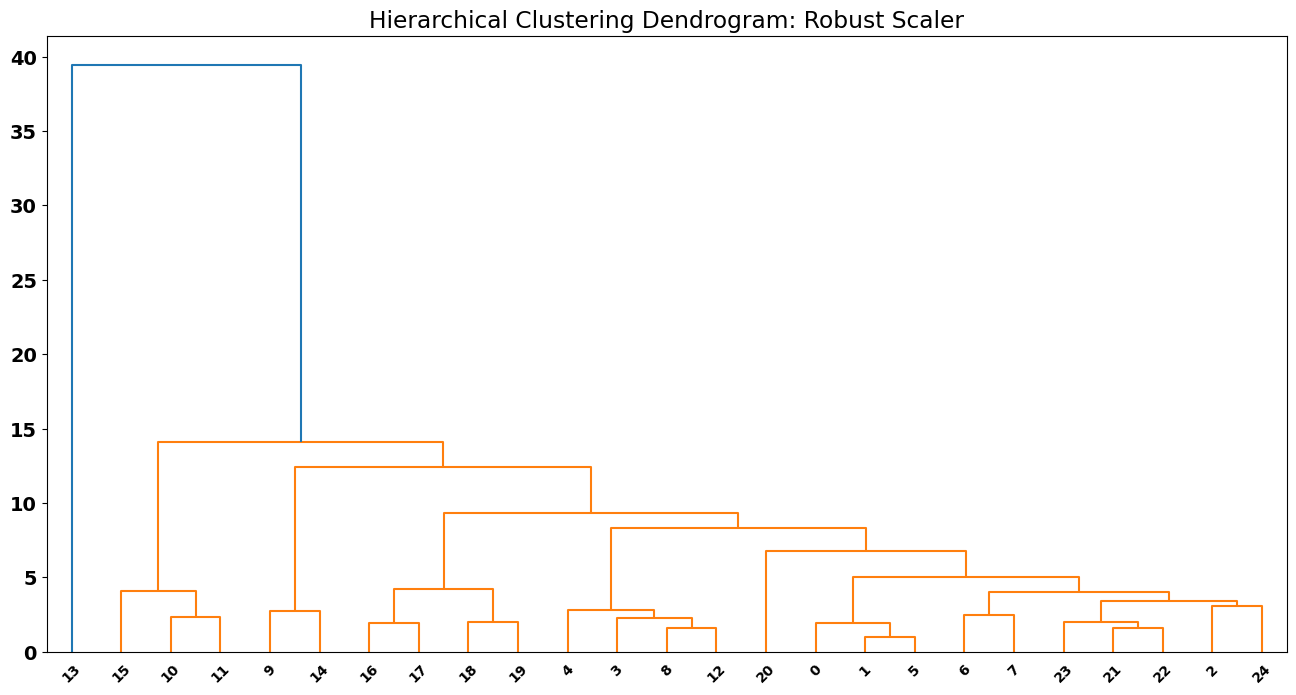

Number of clusters chosen:10


In [20]:
# apply agglomerative clustering on obtained som results
hc_rbsom = AgglomerativeClustering(
    n_clusters = None, distance_threshold = 0,
    linkage='ward').fit(f1_rbsom)

# plot dendrogram to chose final number of clusters
plot_dendrogram(hc_rbsom, truncate_mode="level", p=50)
plt.title('Hierarchical Clustering Dendrogram: Robust Scaler')
plt.show()

n_clusters = int(input('Number of clusters chosen:'))
# apply final agglomerative clustering on the number of clusters chosen
ta_rbsom = AgglomerativeClustering(
    n_clusters = n_clusters,
    linkage='average').fit_predict(f1_rbsom)

# add these to the first df with som results
f1_rbsom['final_clsom'] = ta_rbsom
f1_rbsom = f1_rbsom[['final_clsom']]

In [21]:
# pandas Series containing the final clusters
final_somrb = som_rb['node'].map(f1_rbsom['final_clsom'])
# add these values to the original dataset
f1['cl_som'] = final_somrb

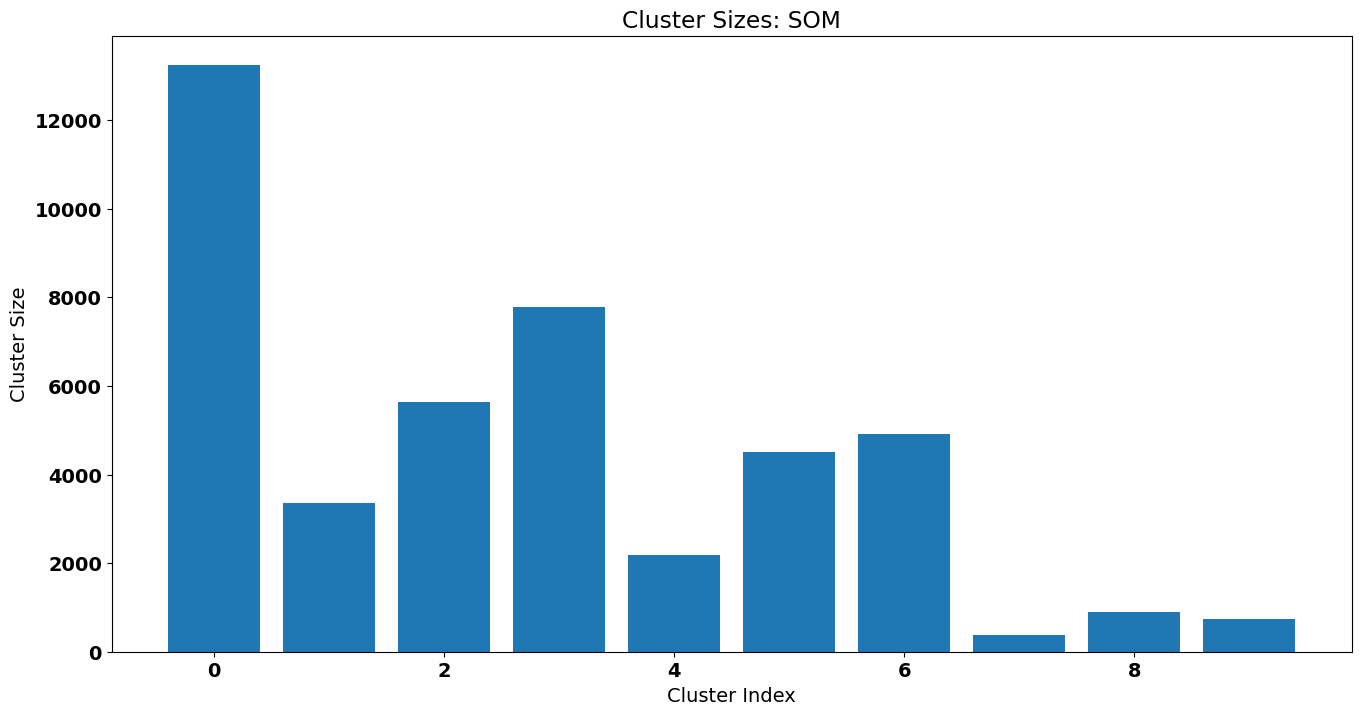

In [22]:
# obtain the cluster sizes
cluster_sizes = f1['cl_som'].value_counts()

# plot to see the varying cluster sizes
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes: SOM')
plt.show()

#### UMAP Visualization on TA2 - 10 clusters

C:\Users\Vidhi Rajanikante\Downloads\AnacondaDistribution.VR\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence

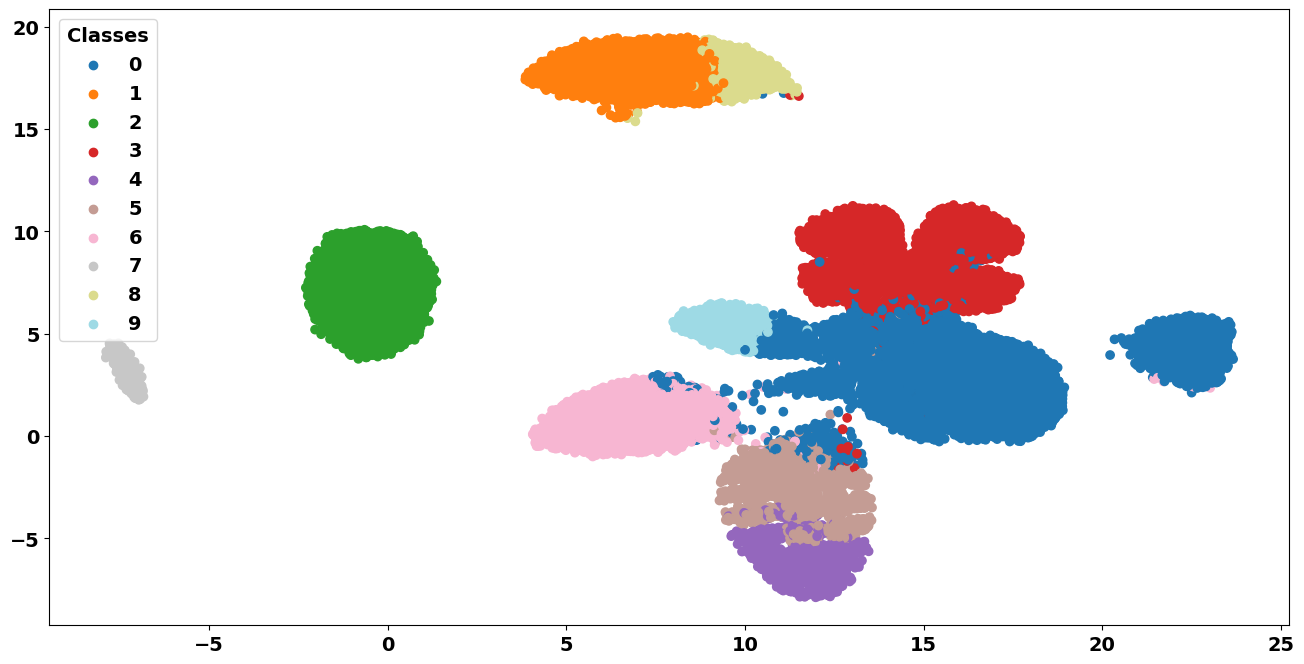

In [23]:
umap_object = umap.UMAP(n_neighbors=200, min_dist=0.7, random_state=42)
train = f1_rb
labels = f1[['cl_som']].sort_index()
umap_embedding = umap_object.fit_transform(train)
visualize_dimensionality_reduction(umap_embedding, labels)

### Joining the clusters of both TA1 and TA2 to get the final clusters
In order to compare the clusters from both tandem approaches, a confusion matrix was created. For getting the final clusters after comparing the both, Hierarchical Clustering was applied to get them.

In [24]:
pd.DataFrame(
    confusion_matrix(f1.cl_km, f1.cl_som),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,10)],
    columns = ['SOM {} Cluster'.format(i) for i in np.arange(0,10)],
)

,SOM 0 Cluster,SOM 1 Cluster,SOM 2 Cluster,SOM 3 Cluster,SOM 4 Cluster,SOM 5 Cluster,SOM 6 Cluster,SOM 7 Cluster,SOM 8 Cluster,SOM 9 Cluster
K-means 0 Cluster,0,3348,0,0,0,0,0,0,874,0
K-means 1 Cluster,376,0,0,0,0,0,0,0,0,739
K-means 2 Cluster,2270,0,0,7728,0,31,0,0,12,0
K-means 3 Cluster,7945,0,0,37,0,3,22,0,8,1
K-means 4 Cluster,218,0,0,15,677,4459,23,0,0,0
K-means 5 Cluster,0,0,5642,0,0,0,0,0,0,0
K-means 6 Cluster,75,0,0,0,0,8,4854,0,0,0
K-means 7 Cluster,0,0,0,0,0,0,0,379,0,0
K-means 8 Cluster,2360,0,0,4,0,1,13,0,1,0
K-means 9 Cluster,0,0,0,0,1506,2,0,0,0,0


In [25]:
f1_fcl = f1_rb.copy()
f1_fcl['cl_km'] = f1['cl_km']
f1_fcl['cl_som'] = f1['cl_som']
f1_fcl = f1_fcl.groupby(['cl_km','cl_som']).mean()

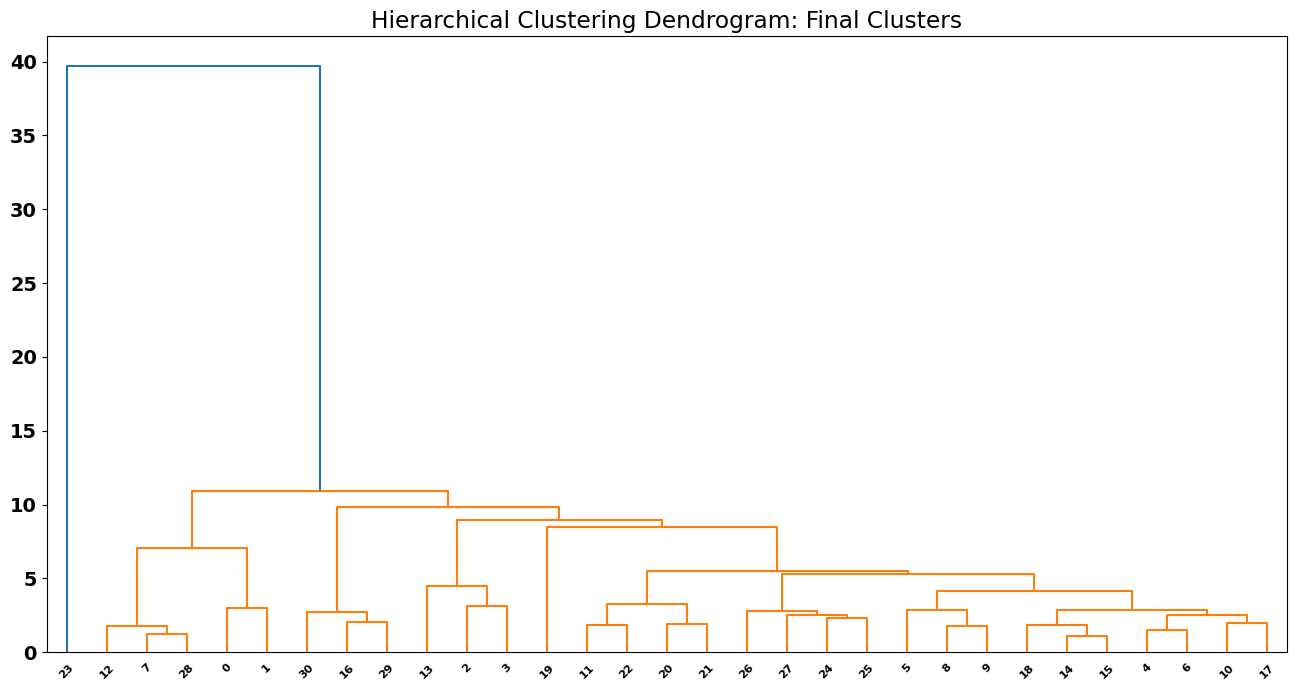

Number of clusters chosen:9


In [26]:
# apply agglomerative clustering on obtained results
hc_fcl = AgglomerativeClustering(
    n_clusters = None, distance_threshold = 0,
    linkage='ward').fit(f1_fcl.drop('customer_id', axis=1))

# plot dendrogram to chose final number of clusters
plot_dendrogram(hc_fcl, truncate_mode="level", p=50)
plt.title('Hierarchical Clustering Dendrogram: Final Clusters')
plt.show()

n_clusters = int(input('Number of clusters chosen:'))
# apply final agglomerative clustering on the final number of clusters chosen
hc_fcl_ = AgglomerativeClustering(
    n_clusters = n_clusters,
    linkage='average').fit_predict(f1_fcl.drop('customer_id', axis=1))

In [27]:
combined = f1[['customer_id', 'cl_km', 'cl_som']]

In [28]:
f1_fcl['final_cl'] = hc_fcl_
f1_fin_clus = f1_fcl[['final_cl']].reset_index()

In [29]:
final_clusters_ = combined.merge(f1_fin_clus, on=['cl_km', 'cl_som'], how= 'left')

In [30]:
f1['final_cl'] = final_clusters_['final_cl']

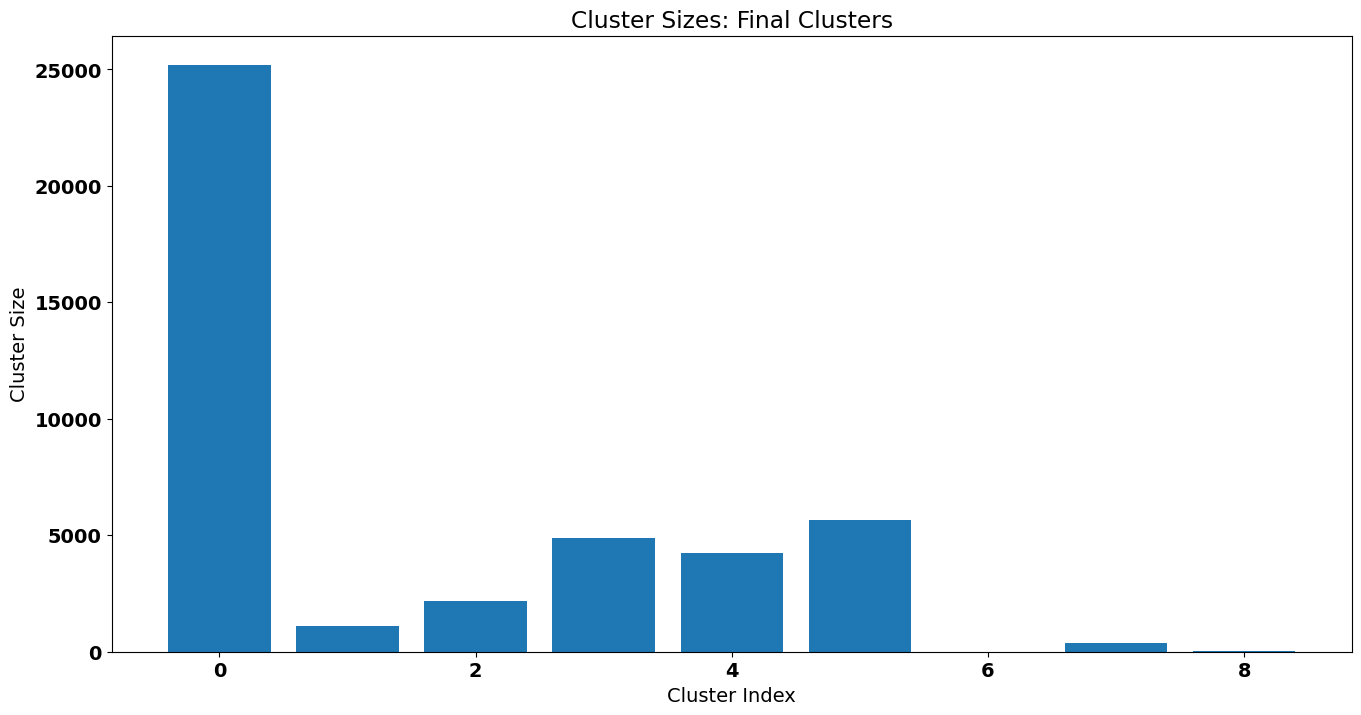

In [31]:
# obtain the cluster sizes
cluster_sizes = f1['final_cl'].value_counts()

# plot to see the varying cluster sizes
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes: Final Clusters')
plt.show()

#### UMAP Visualization on the final clusters - 9 clusters

C:\Users\Vidhi Rajanikante\Downloads\AnacondaDistribution.VR\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence

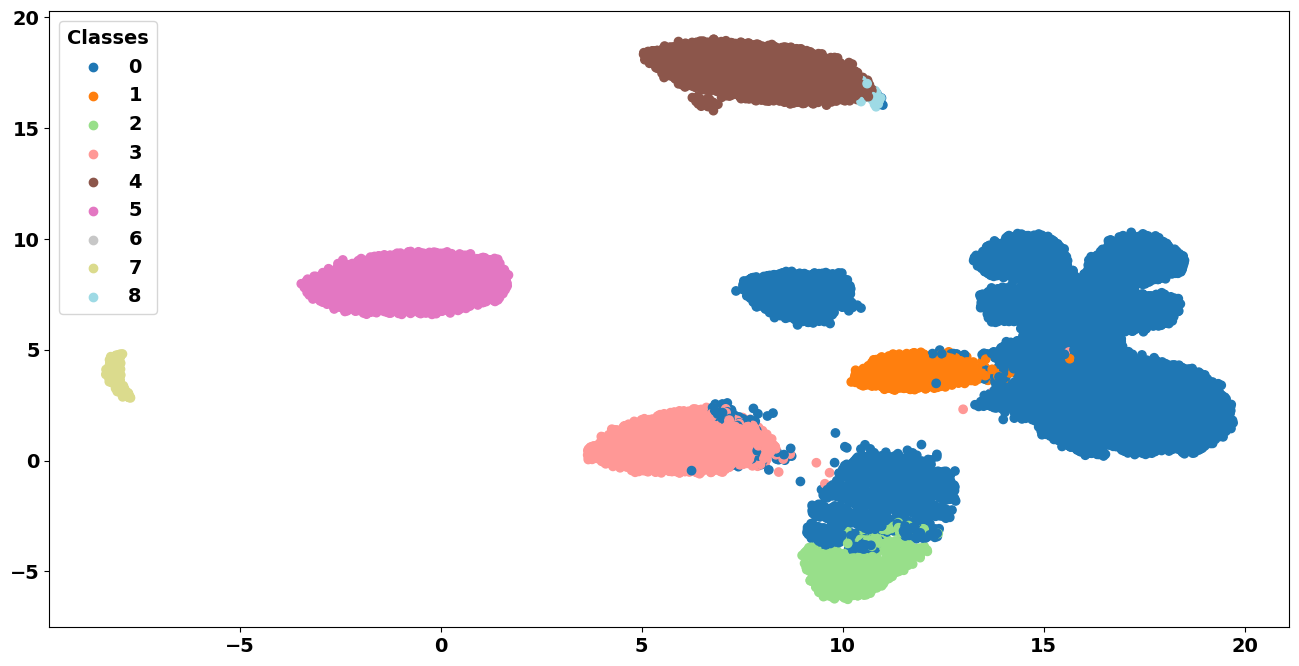

In [32]:
umap_object = umap.UMAP(n_neighbors=200, min_dist=0.5, random_state=42)
train = f1_rb
labels = f1[['final_cl']].sort_index()
umap_embedding = umap_object.fit_transform(train)
visualize_dimensionality_reduction(umap_embedding, labels)

#### Breaking Cluster 0 into smaller clusters

In [34]:
cluster_0 = f1_rb.copy()
cluster_0['final_cl'] = f1['final_cl']
# filtering out the rows where the final cluster is equal to 0
cluster0 = cluster_0.loc[cluster_0['final_cl'] == 0]

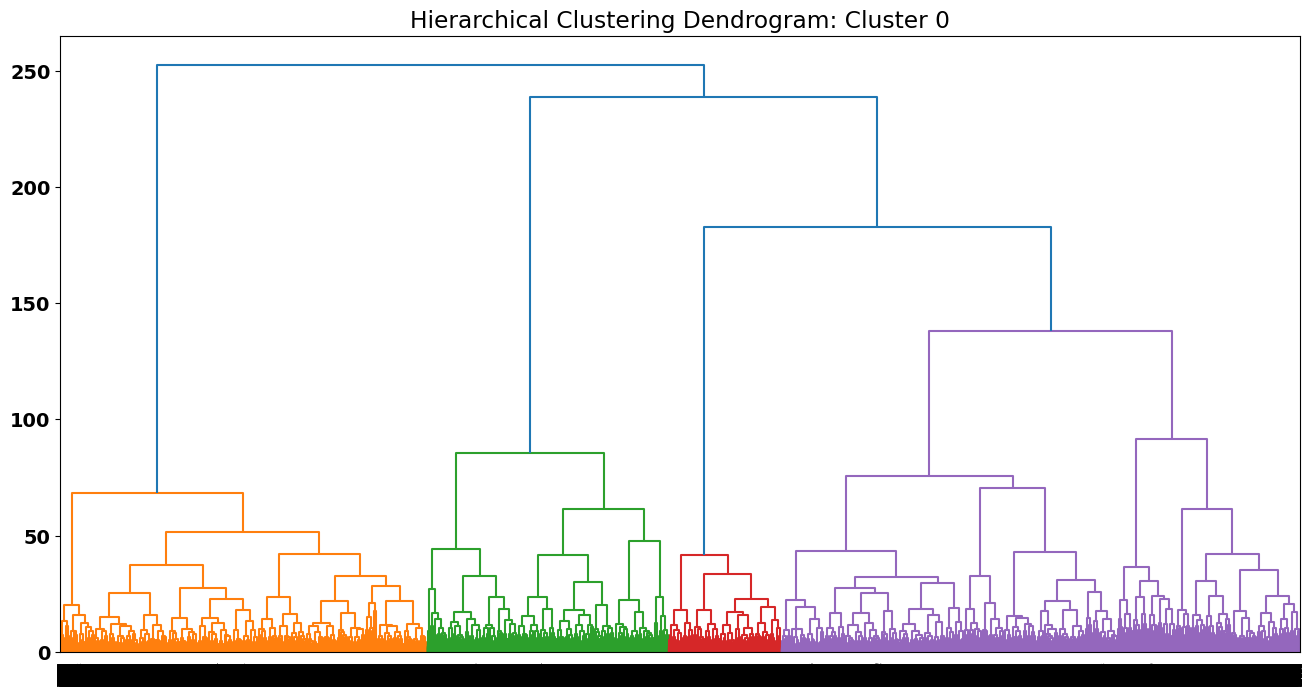

Number of clusters chosen:5


In [35]:
hc_cl0 = AgglomerativeClustering(
    n_clusters = None, distance_threshold = 0,
    linkage='ward').fit(cluster0.drop('customer_id', axis=1))

# plot dendrogram to chose how many clusters to break cluster 0 into
plot_dendrogram(hc_cl0, truncate_mode="level", p=50)
plt.title('Hierarchical Clustering Dendrogram: Cluster 0')
plt.show()
n_clusters = int(input('Number of clusters chosen:'))

# apply final agglomerative clustering on the final number of clusters chosen for cluster0
hc_cl0_ = AgglomerativeClustering(
    n_clusters = n_clusters,
    linkage='ward').fit_predict(cluster0.drop('customer_id', axis=1))

In [38]:
cluster0['cluster'] = hc_cl0_
cluster0['cluster'].unique() # checking if the values are well

C:\Users\Vidhi Rajanikante\AppData\Local\Temp\ipykernel_14456\1262305217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster0['cluster'] = hc_cl0_


array([1, 2, 4, 0, 3], dtype=int64)

In [40]:
# checking how the clusters are distributed
pd.Series(hc_cl0_).value_counts()

4    7462
1    6831
2    4908
0    3699
3    2290
dtype: int64

In [42]:
# joining the 5 clusters into cluster0
cluster0_ = f1.join(cluster0[['cluster']], how='left')

In [43]:
# in order to distinguish between the broken cluster and other clusters
cluster0_['cluster'] = cluster0_['cluster'].apply(lambda x: -x if x is not np.nan else 0)
cluster0_['cluster'] = cluster0_['cluster'].fillna(0)
cluster0_['cluster'].unique()

array([ 0., -1., -2., -4., -3.])

In [47]:
# having 'final_cluster' represent the final broken cluster numbers
cluster0_['final_cluster'] = cluster0_['final_cl'] + cluster0_['cluster']
cluster0_['final_cluster'] = cluster0_['final_cluster'].astype(int)

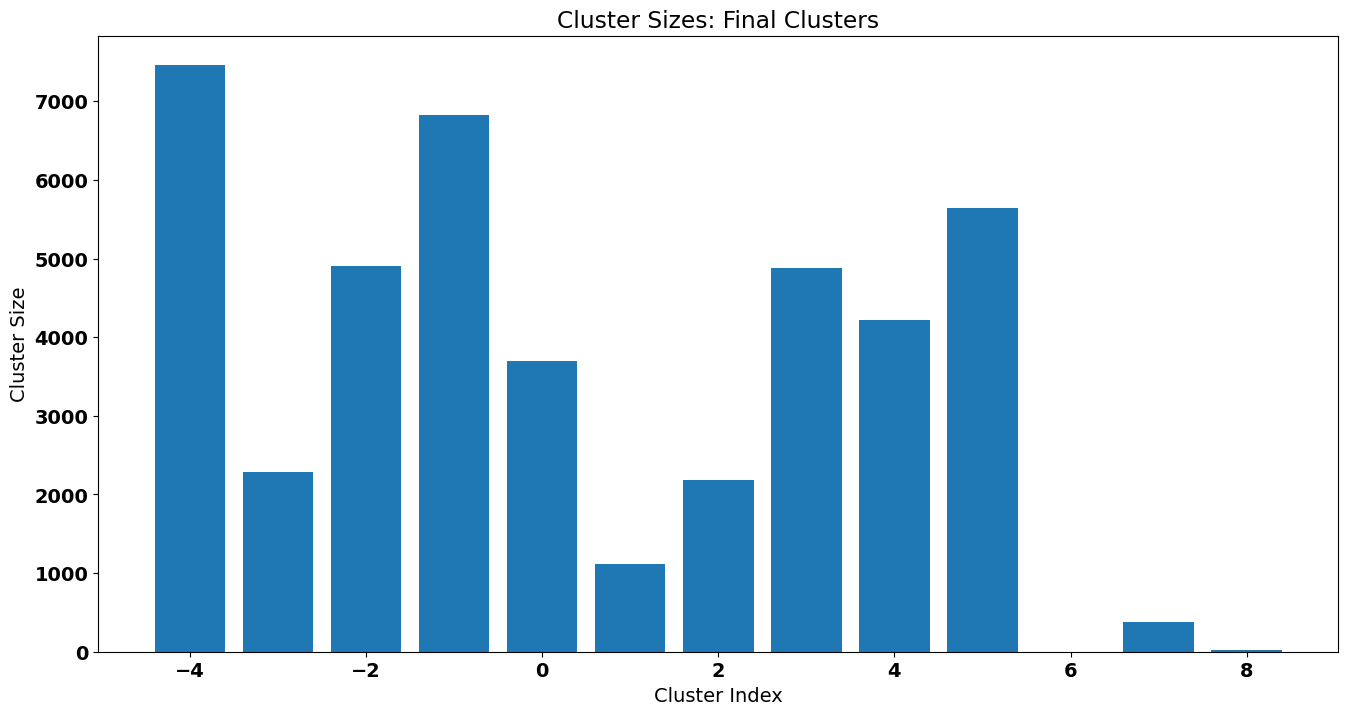

In [45]:
# obtain the cluster sizes
cluster_sizes = cluster0_['final_cluster'].value_counts()

# plot to see the varying cluster sizes
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes: Final Clusters')
plt.show()

#### UMAP Visualization of Final (final) Clusters

C:\Users\Vidhi Rajanikante\Downloads\AnacondaDistribution.VR\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence

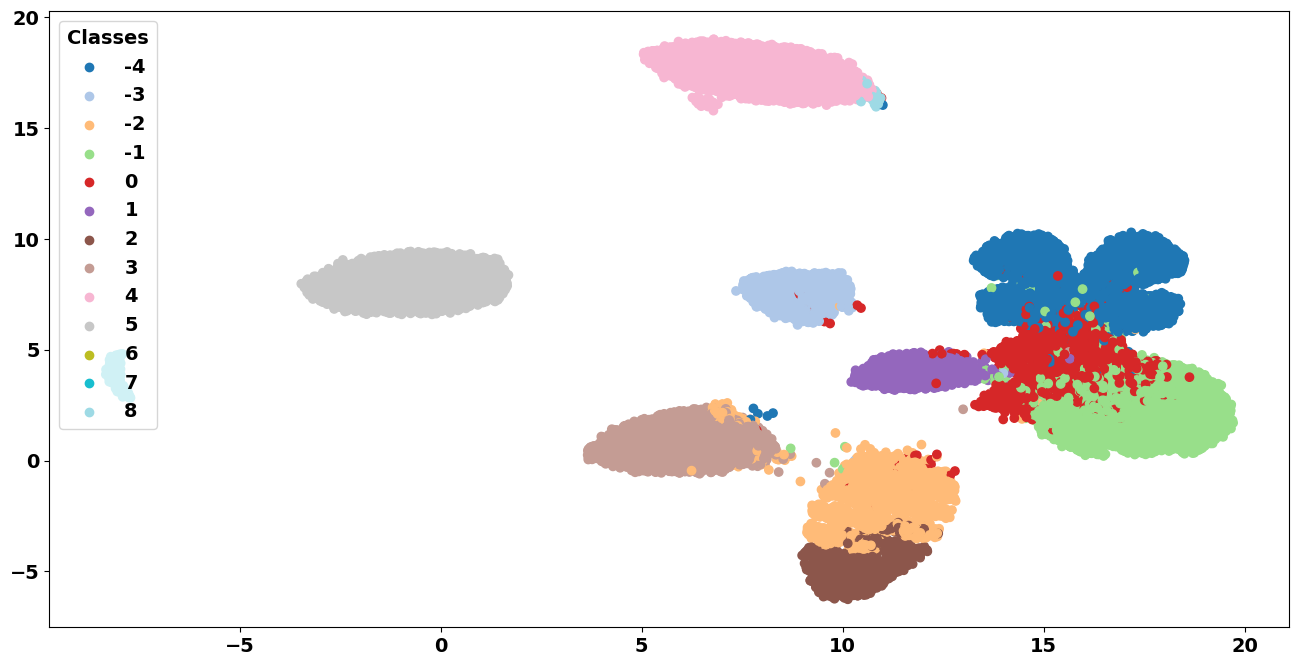

In [50]:
umap_object = umap.UMAP(n_neighbors=200, min_dist=0.5, random_state=42)
train = f1_rb
labels = cluster0_[['final_cluster']].sort_index()
umap_embedding = umap_object.fit_transform(train)
visualize_dimensionality_reduction(umap_embedding, labels)

In [ ]:
# dropping the unnecessary columns to not have redundancy
cluster0_.drop(['final_cl', 'cluster'], axis=1, inplace=True) 
f1 = cluster0_

In [52]:
f1

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,spend_groceries,spend_electronics,typical_hour,spend_vegetables,spend_nonalcohol_drinks,spend_alcohol_drinks,spend_meat,spend_fish,spend_hygiene,spend_videogames,spend_petfood,total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,customer_graduate,cust_buy_yrs,cl_db,cl_km,cl_som,final_cluster
0,39634,David Frink,M,1964,1,1,1,2,18306.0,7106.0,17,484.0,604.0,943.0,2226.0,4056.0,2174.0,3946.0,2514.0,32,0.072206,2010,Nal,14.0,0,5,2,5
1,43460,Belinda Terry,F,1988,1,0,1,2,5015.0,1334.0,8,344.0,374.0,1217.0,1068.0,1925.0,2115.0,1028.0,1987.0,2566,0.206227,2014,Nal,10.0,1,6,6,3
2,23937,Evelyn Calico,F,1969,0,1,1,3,3097.0,4073.0,10,301.0,852.0,1731.0,446.0,2347.0,1306.0,1504.0,2018.0,1282,0.136168,2009,Nal,15.0,1,6,6,3
3,2431,Ora Boggess,F,1941,0,0,0,1,10825.0,207.0,17,153.0,252.0,60.0,285.0,151.0,53.0,0.0,4135.0,70,0.215852,2007,Nal,17.0,1,0,8,4
4,10090,Lonnie Hopson,M,2001,0,0,0,1,697.0,570.0,14,8.0,33.0,2833.0,54.0,172.0,587.0,223.0,64.0,4,0.181023,2024,Nal,0.0,1,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43626,48487,Amelia Crawford,F,1983,1,1,0,1,7189.0,6293.0,17,678.0,741.0,639.0,1569.0,3779.0,1748.0,4387.0,2812.0,14,0.233259,2016,Nal,8.0,0,5,2,5
43627,24856,Silvia Ramos,F,1992,1,1,1,1,11238.0,11490.0,12,602.0,557.0,1503.0,2610.0,3893.0,1621.0,3831.0,2726.0,25,0.060977,2014,Nal,10.0,0,5,2,5
43628,21373,Addie Coronel,F,1994,0,0,0,1,6059.0,241.0,12,289.0,420.0,43.0,331.0,142.0,179.0,0.0,11242.0,44,0.097672,2017,Nal,7.0,1,0,1,4
43629,19527,Msc. Mary Ross,F,1989,1,0,1,1,3098.0,425.0,6,866.0,369.0,222.0,1.0,0.0,393.0,210.0,422.0,178,0.182188,2007,Master_Degree,17.0,1,2,3,-4


### Naming our clusters

In [53]:
f1.groupby(['final_cluster']).mean()
# ignoring 'cust_buy_yrs', 'cl_rbdb', 'cl_km', 'cl_som'

,customer_id,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,spend_groceries,spend_electronics,typical_hour,spend_vegetables,spend_nonalcohol_drinks,spend_alcohol_drinks,spend_meat,spend_fish,spend_hygiene,spend_videogames,spend_petfood,total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,cust_buy_yrs,cl_db,cl_km,cl_som
final_cluster,,,,,,,,,,,,,,,,,,,,,,,,
-4,24964.848164,1969.122755,0.999330,0.426293,0.508175,1.176092,2992.490083,409.937148,13.742562,958.791329,300.007237,135.492361,32.389038,68.418869,500.597561,216.506701,502.583490,211.598767,0.199422,2011.176494,12.823506,0.986331,2.010989,2.946931
-3,25468.607860,1993.434934,0.112664,0.010044,0.027948,1.378603,4994.109170,4059.473799,13.809607,299.063843,298.698690,494.952402,697.900437,982.502882,711.889083,996.323144,842.923581,571.376419,0.201663,2015.700000,8.300000,0.999127,7.990830,0.030131
-2,24731.670130,1968.727384,2.095966,1.841891,0.989405,1.122861,5035.280562,2011.344336,17.299715,493.360228,502.851874,309.101059,1001.187653,1042.229992,1023.129177,1001.719438,1024.929707,504.966381,0.196913,2010.933374,13.066626,0.987368,4.058272,4.586186
-1,25182.393793,1969.747475,0.559362,0.950227,0.938076,2.395403,2042.328942,223.858147,12.284146,223.862275,306.913483,305.640902,414.092373,521.440023,498.610013,403.440492,595.574294,401.811448,0.526714,2011.266579,12.733421,0.983311,2.965891,0.042600
0,25232.880508,1966.411733,0.834009,0.868883,0.758313,2.125439,2100.505812,440.261422,13.411192,380.247391,455.802920,559.785077,505.748040,544.461638,551.476345,440.277643,553.592593,418.842660,0.185198,2010.709381,13.290619,0.680995,2.409300,0.329549
1,24923.339910,1999.889686,0.319283,0.025112,0.018834,1.372197,919.545291,490.985650,18.642152,103.824395,509.675336,2003.932735,189.248430,204.502780,502.314798,310.218834,119.385650,60.138117,0.104660,2021.730942,2.269058,0.967713,1.000000,5.965022
2,24682.780778,1969.765217,5.149657,2.256751,0.986728,1.107094,5046.991304,2052.128604,17.500229,501.360000,502.524485,300.700229,1009.593593,995.850252,998.359725,998.561098,993.448055,522.248055,0.201698,2011.654920,12.345080,0.969794,7.450801,4.000915
3,24876.361567,1968.977235,0.996514,0.814807,0.994053,1.996924,5063.850902,2113.122847,9.636998,299.057629,598.180066,1009.018663,1002.629820,1979.295037,2008.466366,1002.685808,1999.567473,1073.438474,0.201563,2008.525021,15.474979,0.897867,5.986464,6.000000
4,24764.909048,1968.663193,0.005211,0.016343,0.503790,1.008527,10152.084794,159.854334,11.917101,199.371435,498.977025,40.348650,202.004263,256.700711,79.217669,0.000000,10052.645429,51.665798,0.197729,2011.053766,12.946234,0.987210,0.000000,2.449076


- Cluster -4: Fake Vegetarians
- Cluster -3: Millenials
- Cluster -2: Gamer Parents
- Cluster -1: Misers
- Cluster 0: Local Folks
- Cluster 1: Youngsters
- Cluster 2: Balanced Parents
- Cluster 3: Karens
- Cluster 4: Petters
- Cluster 5: Settled Techies
- Cluster 6: Dirty Oldies
- Cluster 7: Stingy Pescatarians
- Cluster 8: Retired Elders

In [54]:
# creating a dictionary with the cluster number and its corresponding custom cluster name
finalcl_names = {-4: 'Fake Vegetarians', -3: 'Millenials', -2: 'Gamer Parents', -1: 'Misers', 
                 0: 'Local Folks', 1: 'Youngsters', 2: 'Balanced Parents', 
                 3: 'Karens', 4: 'Petters', 5: 'Settled Techies', 6: 'Dirty Oldies', 
                 7: 'Stingy Pescatarians', 8: 'Retired Elders'}

In [55]:
# substitute the cluster numbers with the cluster names
f1['final_cluster'] = f1['final_cluster'].map(finalcl_names)

### Exports

In [56]:
# create a dataframe consisting of only the customer_id and final_cl columns
cl_finaldf = f1[['customer_id', 'final_cluster']]

In [57]:
cl_finaldf

,customer_id,final_cluster
0,39634,Settled Techies
1,43460,Karens
2,23937,Karens
3,2431,Petters
4,10090,Youngsters
...,...,...
43626,48487,Settled Techies
43627,24856,Settled Techies
43628,21373,Petters
43629,19527,Fake Vegetarians


In [58]:
# saving the KMeans clusters, SOM clusters and all clusters, with their associated customer_id, DataFrames 
# to a csv file to then import it in the Association Rules notebook
cl_finaldf.to_csv('files_toimport/final_clusters.csv')